<a href="https://colab.research.google.com/github/ykato27/Text-to-Speech/blob/main/ch07_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7章 WaveNet: 深層学習に基づく音声波形の生成モデル

## 準備

### Python version

In [1]:
!python -VV

Python 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


### ttslearn のインストール

In [2]:
%%capture
try:
    import ttslearn
except ImportError:
    !pip install ttslearn

In [3]:
import ttslearn
ttslearn.__version__

'0.2.1'

### パッケージのインポート

In [4]:
%pylab inline
%load_ext autoreload
%load_ext tensorboard
%autoreload
import IPython
from IPython.display import Audio
import tensorboard as tb
import os

Populating the interactive namespace from numpy and matplotlib


In [5]:
# 数値演算
import numpy as np
import torch
from torch import nn
# 音声波形の読み込み
from scipy.io import wavfile
# 音声分析、可視化
import librosa
import librosa.display
# Pythonで学ぶ音声合成
import ttslearn

In [6]:
# シードの固定
from ttslearn.util import init_seed
init_seed(773)

In [7]:
torch.__version__

'1.9.0+cu102'

### 描画周りの設定

In [8]:
from ttslearn.notebook import get_cmap, init_plot_style, savefig
cmap = get_cmap()
init_plot_style()

## 7.3 WaveNetにおける音声波形の扱い

### $\mu$-law アルゴリズム

In [9]:
def mulaw(x, mu=255):
    return np.sign(x) * np.log1p(mu * np.abs(x)) / np.log1p(mu)

def quantize(y, mu=255, offset=1):
    # [-1, 1] -> [0, 2] -> [0, 1] -> [0, mu]
    return ((y + offset) / 2 * mu).astype(np.int64)    

def mulaw_quantize(x, mu=255):
    return quantize(mulaw(x, mu), mu)

#### $\mu$-law アルゴリズム適用前

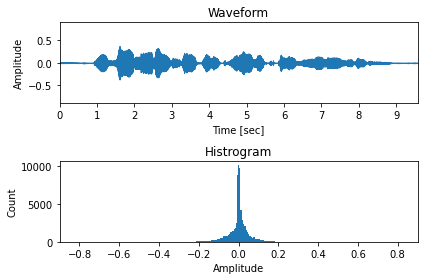

In [10]:
sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = (x / 32768.0).astype(np.float32)

mu = 2**8-1 # 8-bit

fig, ax = plt.subplots(2, 1, figsize=(6,4))
ax[0].set_title("Waveform")
ax[1].set_title("Histrogram")

ax[0].set_ylim(-0.9, 0.9)
librosa.display.waveplot(x, ax=ax[0], sr=16000)

ax[1].set_xlim(-0.9, 0.9)
ax[1].hist(x, bins=mu)

ax[0].set_xlabel("Time [sec]")
ax[0].set_ylabel("Amplitude")
ax[1].set_xlabel("Amplitude")
ax[1].set_ylabel("Count")

plt.tight_layout()

# 図7-6 (a)
savefig("./fig/wavenet_mulaw_a")

#### $\mu$-law アルゴリズム適用後

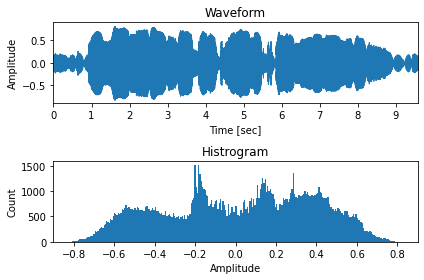

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6,4))
ax[0].set_title("Waveform")
ax[1].set_title("Histrogram")

ax[0].set_ylim(-0.9, 0.9)
librosa.display.waveplot(mulaw(x), ax=ax[0], sr=16000)

ax[1].set_xlim(-0.9, 0.9)
ax[1].hist(mulaw(x), bins=mu)

ax[0].set_xlabel("Time [sec]")
ax[0].set_ylabel("Amplitude")
ax[1].set_xlabel("Amplitude")
ax[1].set_ylabel("Count")

plt.tight_layout()

# 図7-6 (b)
savefig("./fig/wavenet_mulaw_b")

### $\mu$-law アルゴリズムによる逆変換

In [12]:
def inv_mulaw(y, mu=255):
    return np.sign(y) * (1.0 / mu) * ((1.0 + mu)**np.abs(y) - 1.0)

def inv_quantize(y, mu):
    # [0, mu] -> [-1, 1]
    return 2 * y.astype(np.float32) / mu - 1

def inv_mulaw_quantize(y, mu=255):
    return inv_mulaw(inv_quantize(y, mu), mu)

#### $\mu$-law なし

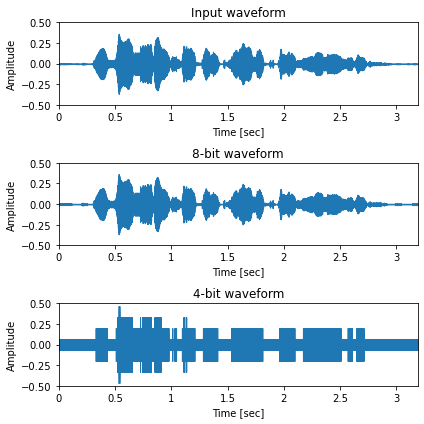

In [13]:
sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = (x / 32768.0).astype(np.float32)  
x = librosa.resample(x, sr, 16000)
sr = 16000

bits = [8, 4]

fig, ax = plt.subplots(len(bits)+1, 1, figsize=(6,2*(len(bits)+1)), sharey=True)
ax[0].set_title("Input waveform")
librosa.display.waveplot(x, sr, x_axis="time", ax=ax[0])
IPython.display.display(Audio(x, rate=sr))

for idx, bit in enumerate(bits):
    mu = 2**bit - 1
    x_hat = inv_quantize(quantize(x, mu), mu)
    librosa.display.waveplot(x_hat, sr, x_axis="time", ax=ax[idx+1])
    ax[idx+1].set_title(f"{bit}-bit waveform")
    IPython.display.display(Audio(x_hat, rate=sr))

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
    a.set_xticks(np.arange(0, 3.5, 0.5))
    a.set_ylim(-0.5, 0.5)
plt.tight_layout()

# 図7-7 (a)
savefig("./fig/wavenet_inv_mulaw_waveform_a")

#### $\mu$-law あり

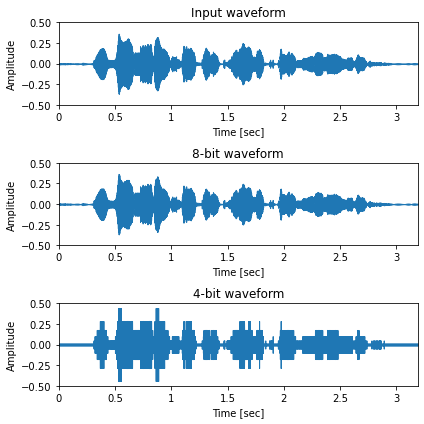

In [14]:
sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = (x / 32768.0).astype(np.float32)  
x = librosa.resample(x, sr, 16000)
sr = 16000

bits = [8, 4]

fig, ax = plt.subplots(len(bits)+1, 1, figsize=(6,2*(len(bits)+1)), sharey=True)
ax[0].set_title("Input waveform")
librosa.display.waveplot(x, sr, x_axis="time", ax=ax[0])
IPython.display.display(Audio(x, rate=sr))

for idx, bit in enumerate(bits):
    mu = 2**bit - 1
    x_hat = inv_mulaw_quantize(mulaw_quantize(x, mu), mu)
    librosa.display.waveplot(x_hat, sr, x_axis="time", ax=ax[idx+1])
    ax[idx+1].set_title(f"{bit}-bit waveform")
    IPython.display.display(Audio(x_hat, rate=sr))

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
    a.set_xticks(np.arange(0, 3.5, 0.5))
    a.set_ylim(-0.5, 0.5)
plt.tight_layout()

# 図7-7 (b)
savefig("./fig/wavenet_inv_mulaw_waveform_b")

## 7.4 因果的な膨張畳み込み

### 1次元の畳み込み

In [15]:
def _toy_1d_input():
    # (B, C, T) where B and C = 1
    return torch.tensor([1,2,3,0,1,2,4],dtype=torch.float).view(1,1,-1)

#### パディングを行わない場合

In [16]:
conv = nn.Conv1d(1,1,3,bias=False, padding=0)
conv.weight.data[0,0,:] = torch.tensor([1,2,4],dtype=torch.float)

x = _toy_1d_input()
with torch.no_grad():
    y= conv(x)
print("入力:", x.long().view(-1).tolist())
print("出力:", y.long().view(-1).tolist())

入力: [1, 2, 3, 0, 1, 2, 4]
出力: [17, 8, 7, 10, 21]


#### パディングを行う場合

In [17]:
conv = nn.Conv1d(1,1,3,bias=False, padding=1)
conv.weight.data[0,0,:] = torch.tensor([1,2,4],dtype=torch.float)

x = _toy_1d_input()
with torch.no_grad():
    y= conv(x)
print("入力:", x.long().view(-1).tolist())
print("出力:", y.long().view(-1).tolist())

入力: [1, 2, 3, 0, 1, 2, 4]
出力: [10, 17, 8, 7, 10, 21, 10]


#### 2層の1次元畳み込み

In [18]:
conv = nn.Conv1d(1,1,3,bias=False, padding=1)
conv.weight.data[0,0,:] = torch.tensor([1,2,4],dtype=torch.float)

x = _toy_1d_input()
with torch.no_grad():
    y= conv(conv(x))
print("入力:", x.long().view(-1).tolist())
print("出力:", y.long().view(-1).tolist())

入力: [1, 2, 3, 0, 1, 2, 4]
出力: [88, 76, 61, 62, 111, 92, 41]


### 因果的な畳み込み

In [19]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()
        self.padding = (kernel_size - 1)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, **kwargs)

    def forward(self, x):
        # 1 次元畳み込み
        y = self.conv(x)
        # 因果性を担保するために、順方向にシフトする
        if self.padding > 0:
            y = y[:, :, :-self.padding]
        return y

In [20]:
conv = CausalConv1d(1,1,3,bias=False)
# テスト用に、畳み込みカーネルを手動で設定
conv.conv.weight.data[0,0,:] = torch.tensor([1,2,4],dtype=torch.float)

x = _toy_1d_input()
y= conv(x)
print("入力:", x.long().view(-1).tolist())
print("出力:", y.long().view(-1).tolist())

入力: [1, 2, 3, 0, 1, 2, 4]
出力: [4, 10, 17, 8, 7, 10, 21]


### 1次元膨張畳み込み

In [21]:
class DilatedCausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super().__init__()
        # パディングの幅を計算する際に、 dilation factor を考慮する必要があることに注意        
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        # 1 次元畳み込み        
        y = self.conv(x)
        # 因果性を担保するために、順方向にシフトする
        if self.padding > 0:
            y = y[:, :, :-self.padding]
        return y

In [22]:
conv = DilatedCausalConv1d(1,1,3,dilation=2, bias=False)
# テスト用に、畳み込みカーネルを手動で設定
conv.conv.weight.data[0,0,:] = torch.tensor([1,2,4],dtype=torch.float)

x = _toy_1d_input()
y= conv(x)
print("入力:", x.long().view(-1).tolist())
print("出力:", y.long().view(-1).tolist())

入力: [1, 2, 3, 0, 1, 2, 4]
出力: [4, 8, 14, 4, 11, 10, 21]


## 7.5 ゲート付き活性化関数を用いた一次元畳み込み

In [23]:
class GatedDilatedCausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels*2, kernel_size, padding=self.padding, dilation=dilation)
        
    def forward(self, x):
        # 1 次元畳み込み                
        y = self.conv(x)
        
        # 因果性を担保するために、順方向にシフトする
        if self.padding > 0:
            y = y[:, :, :-self.padding]

        # チャネル方向に分割
        a, b = y.split(y.size(1) // 2, dim=1)
        
        # ゲート付き活性化関数の適用
        y = torch.tanh(a) * torch.sigmoid(b)

        return y

In [24]:
conv = GatedDilatedCausalConv1d(128, 16, 3, dilation=2)
x = torch.ones(32, 128, 100)
print("入力のサイズ：", tuple(x.shape))
print("出力のサイズ：", tuple(conv(x).shape))

入力のサイズ： (32, 128, 100)
出力のサイズ： (32, 16, 100)


## 7.6 条件付け特徴量のアップサンプリング

### 繰り返しに基づくアップサンプリング

In [25]:
x = torch.tensor([[1, 2, 3],[1, 2, 3],[1,2,3]]).view(1,3,-1).float()
y = nn.Upsample(scale_factor=3, mode="nearest")(x)
print(x)
print(y)

tensor([[[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]]])
tensor([[[1., 1., 1., 2., 2., 2., 3., 3., 3.],
         [1., 1., 1., 2., 2., 2., 3., 3., 3.],
         [1., 1., 1., 2., 2., 2., 3., 3., 3.]]])


In [26]:
class RepeatUpsampling(nn.Module):
    def __init__(self, upsample_scales):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=np.prod(upsample_scales), mode="nearest")

    def forward(self, c):
        return self.upsample(c)

In [27]:
c = torch.ones(32, 80, 10)
# 例として、100倍にアップサンプリング
c_up = RepeatUpsampling([100])(c)

print("入力のサイズ：", tuple(c.shape))
print("出力サイズ：", tuple(c_up.shape))

入力のサイズ： (32, 80, 10)
出力サイズ： (32, 80, 1000)


### 最近傍補間と畳み込みの併用に基づくアップサンプリング

In [28]:
from torch.nn import functional as F

class UpsampleNetwork(nn.Module):
    def __init__(self, upsample_scales):
        super().__init__()
        self.upsample_scales = upsample_scales
        self.conv_layers = nn.ModuleList()
        for scale in upsample_scales:
            kernel_size = (1, scale * 2 + 1)
            conv = nn.Conv2d(
                1, 1, kernel_size=kernel_size, padding=(0, scale), bias=False
            )
            conv.weight.data.fill_(1.0 / np.prod(kernel_size))
            self.conv_layers.append(conv)

    def forward(self, c):
        # (B, 1, C, T)
        c = c.unsqueeze(1)
        # 最近傍補完と畳み込みの繰り返し
        for idx, scale in enumerate(self.upsample_scales):
            # 時間方向にのみアップサンプリング
            # (B, 1, C, T) -> (B, 1, C, T*scale)
            c = F.interpolate(c, scale_factor=(1, scale), mode="nearest")
            c = self.conv_layers[idx](c)
        # B x C x T
        return c.squeeze(1)

In [29]:
c = torch.ones(32, 80, 10)
c_up = UpsampleNetwork([10, 8])(c)

print("入力のサイズ：", tuple(c.shape))
print("出力サイズ：", tuple(c_up.shape))

入力のサイズ： (32, 80, 10)
出力サイズ： (32, 80, 800)


#### 実データ (mel-spectrogram) のアップサンプリング (bonus)

書籍では解説しませんでしたが、二次元畳み込みの重みを適切に初期化することで、畳み込みの前後でスケールが保持されることを示します。

In [30]:
# 初期化の影響を確認するため、畳み込みのパラメータを乱数で初期化
class RandomInitUpsampleNetwork(UpsampleNetwork):
    def __init__(self, upsample_scales):
        super().__init__(upsample_scales)
        for conv in self.conv_layers:
            nn.init.normal_(conv.weight.data, 0, 1.0)

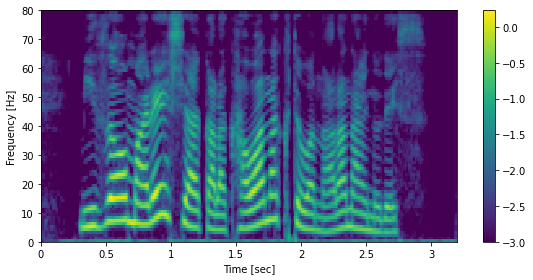

In [31]:
from ttslearn.dsp import logmelspectrogram

_sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = (x / 32768.0).astype(np.float32)
sr = 16000
x = librosa.resample(x, _sr, sr)
hop_length = int(0.0125 * sr)
sp = logmelspectrogram(x, sr, hop_length=hop_length)

fig, ax = plt.subplots(figsize=(8,4))
mesh = librosa.display.specshow(sp.T, sr=sr, hop_length=hop_length, cmap=cmap, x_axis="time", y_axis="frames")
fig.colorbar(mesh, ax=ax)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Frequency [Hz]")
plt.tight_layout()

Audio(x, rate=sr)

In [32]:
upsample_net = UpsampleNetwork([10, 8])
upsample_net

UpsampleNetwork(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 1, kernel_size=(1, 21), stride=(1, 1), padding=(0, 10), bias=False)
    (1): Conv2d(1, 1, kernel_size=(1, 17), stride=(1, 1), padding=(0, 8), bias=False)
  )
)

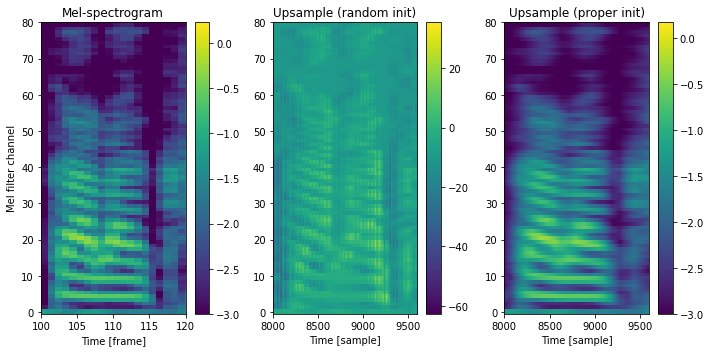

In [33]:
tsp = torch.from_numpy(sp.T).view(1, 80, -1)

# 畳み込みのカーネルを適切に初期化した場合
tsp_up = upsample_net(tsp)

# ランダムに初期化した場合
torch.manual_seed(0)
upsample_net_rand_init = RandomInitUpsampleNetwork([10, 8])

tsp_up_rand_init = upsample_net_rand_init(tsp)

A = tsp.squeeze(0).numpy()
B = tsp_up_rand_init.squeeze(0).detach().numpy()
C = tsp_up.squeeze(0).detach().numpy()

s, e = 100, 120

fig, ax = plt.subplots(1, 3, figsize=(10,5))
ax[0].set_title("Mel-spectrogram")
ax[1].set_title("Upsample (random init)")
ax[2].set_title("Upsample (proper init)")

ax[0].set_xlim(s, e)
ax[0].imshow(A, aspect="auto", interpolation="nearest", origin="lower", cmap=cmap)
fig.colorbar(ax[0].pcolormesh(A, cmap=cmap, rasterized=True), ax=ax[0])

ax[1].set_xlim(s*80, e*80)
ax[1].imshow(B, aspect="auto", interpolation="nearest", origin="lower", cmap=cmap)
fig.colorbar(ax[1].pcolormesh(B, cmap=cmap, rasterized=True), ax=ax[1])

ax[2].set_xlim(s*80, e*80)
ax[2].imshow(C, aspect="auto", interpolation="nearest", origin="lower", cmap=cmap)
fig.colorbar(ax[2].pcolormesh(C, cmap=cmap, rasterized=True), ax=ax[2])

for a in ax:
    # あとでラベルを付け直すので、ここでは消しておく
    a.set_ylabel("")

ax[0].set_ylabel("Mel filter channel")
ax[0].set_xlabel("Time [frame]")
for a in ax[1:]:
    a.set_xlabel("Time [sample]")
    
plt.tight_layout()

### 近傍の条件付け特徴量を考慮するアップサンプリング

In [34]:
class ConvInUpsampleNetwork(nn.Module):
    def __init__(self, upsample_scales, cin_channels, aux_context_window):
        super(ConvInUpsampleNetwork, self).__init__()
        # 条件付き特徴量の時間方向の近傍情報を、1 次元畳み込みによって考慮する
        kernel_size = 2 * aux_context_window + 1
        self.conv_in = nn.Conv1d(cin_channels, cin_channels, kernel_size, bias=False)
        # アップサンプリング
        self.upsample = UpsampleNetwork(upsample_scales)

    def forward(self, c):
        c_up = self.upsample(self.conv_in(c))
        return c_up

In [35]:
c = torch.ones(32, 80, 10)

c_up = ConvInUpsampleNetwork([10, 8], 80, 2)(c)
print("入力のサイズ：", tuple(c.shape))
print("出力サイズ：", tuple(c_up.shape))

入力のサイズ： (32, 80, 10)
出力サイズ： (32, 80, 480)


## 7.7 WaveNetの実装

### 1 x 1 畳み込み

In [36]:
def Conv1d1x1(in_channels, out_channels, bias=True):
    return nn.Conv1d(
        in_channels, out_channels, kernel_size=1, padding=0, dilation=1, bias=bias
    )


### 畳み込みブロック

In [37]:
class ResSkipBlock(nn.Module):
    def __init__(
        self,
        residual_channels,  # 残差結合のチャネル数
        gate_channels,  # ゲートのチャネル数
        kernel_size,  # カーネルサイズ
        skip_out_channels,  # スキップ結合のチャネル数
        dilation=1,  # dilation factor
        cin_channels=80,  # 条件付特徴量のチャネル数
        *args,
        **kwargs,
    ):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation

        # 1 次元膨張畳み込み (dilation == 1 のときは、通常の 1 次元畳み込み)
        self.conv = nn.Conv1d(
            residual_channels,
            gate_channels,
            kernel_size,
            padding=self.padding,
            dilation=dilation,
            *args,
            **kwargs,
        )

        # local conditioning 用の 1x1 convolution
        self.conv1x1c = Conv1d1x1(cin_channels, gate_channels, bias=False)

        # ゲート付き活性化関数のために、1 次元畳み込みの出力は 2 分割されることに注意
        gate_out_channels = gate_channels // 2
        self.conv1x1_out = Conv1d1x1(gate_out_channels, residual_channels)
        self.conv1x1_skip = Conv1d1x1(gate_out_channels, skip_out_channels)

    def forward(self, x, c):
        # 残差接続用に入力を保持
        residual = x

        # 1 次元畳み込み
        splitdim = 1  # (B, C, T)
        x = self.conv(x)
        # 因果性を保証するために、出力をシフトする
        x = x[:, :, : -self.padding]

        # チャネル方向で出力を分割
        a, b = x.split(x.size(1) // 2, dim=1)

        # local conditioning
        c = self.conv1x1c(c)
        ca, cb = c.split(c.size(1) // 2, dim=1)
        a, b = a + ca, b + cb

        # ゲート付き活性化関数
        x = torch.tanh(a) * torch.sigmoid(b)

        # スキップ接続用の出力を計算
        s = self.conv1x1_skip(x)

        # 残差接続の要素和を行う前に、次元数を合わせる
        x = self.conv1x1_out(x)

        x = x + residual

        return x, s

In [38]:
kernel_size = 3
conv = ResSkipBlock(128,16,kernel_size, 64, dilation=4)
x = torch.ones(32, 128, 100)
c = torch.ones(32, 80, 100)
out, skip = conv(x, c)
out.shape, skip.shape

(torch.Size([32, 128, 100]), torch.Size([32, 64, 100]))

### WaveNet全体の実装

In [39]:
# 受容野の大きさを数式通り愚直に計算
(2 - 1) * sum([1,2,4,8,16,32,64,128,256,512]) * 3 + 1

3070

In [40]:
# 受容野の大きさを計算する関数
from ttslearn.wavenet import receptive_field_size

for layers, stacks, kernel_size in [
    (30, 3, 2), # WaveNetの論文の設定
]:
    print(f"[Layers: {layers}, Dilation cycles: {stacks}, kernel size: {kernel_size}]: recepive field (ミリ秒):")
    size = receptive_field_size(layers, stacks, kernel_size)
    print(f"{size} samples ({size / 16000 * 1000} ミリ秒)")

[Layers: 30, Dilation cycles: 3, kernel size: 2]: recepive field (ミリ秒):
3070 samples (191.875 ミリ秒)


In [41]:
class WaveNet(nn.Module):
    def __init__(
        self,
        out_channels=256,  # 出力のチャネル数
        layers=30,  # レイヤー数
        stacks=3,  # 畳み込みブロックの数
        residual_channels=64,  # 残差結合のチャネル数
        gate_channels=128,  # ゲートのチャネル数
        skip_out_channels=64,  # スキップ接続のチャネル数
        kernel_size=2,  # 1 次元畳み込みのカーネルサイズ
        cin_channels=80,  # 条件付け特徴量のチャネル数
        upsample_scales=None,  # アップサンプリングのスケール
        aux_context_window=0,  # アップサンプリング時に参照する近傍フレーム数
    ):
        super().__init__()
        self.out_channels = out_channels
        self.cin_channels = cin_channels
        self.aux_context_window = aux_context_window
        if upsample_scales is None:
            upsample_scales = [10, 8]
        self.upsample_scales = upsample_scales

        self.first_conv = Conv1d1x1(out_channels, residual_channels)

        # メインとなる畳み込み層
        self.main_conv_layers = nn.ModuleList()
        layers_per_stack = layers // stacks
        for layer in range(layers):
            dilation = 2 ** (layer % layers_per_stack)
            conv = ResSkipBlock(
                residual_channels,
                gate_channels,
                kernel_size,
                skip_out_channels,
                dilation=dilation,
                cin_channels=cin_channels,
            )
            self.main_conv_layers.append(conv)

        # スキップ接続の和から波形への変換
        self.last_conv_layers = nn.ModuleList(
            [
                nn.ReLU(),
                Conv1d1x1(skip_out_channels, skip_out_channels),
                nn.ReLU(),
                Conv1d1x1(skip_out_channels, out_channels),
            ]
        )

        # フレーム単位の特徴量をサンプル単位にアップサンプリング
        self.upsample_net = ConvInUpsampleNetwork(
            upsample_scales, cin_channels, aux_context_window
        )

    def forward(self, x, c):
        # 量子化された離散値列から One-hot ベクトルに変換
        # (B, T) -> (B, T, out_channels) -> (B, out_channels, T)
        x = F.one_hot(x, self.out_channels).transpose(1, 2).float()

        # 条件付け特徴量のアップサンプリング
        c = self.upsample_net(c)

        # One-hot ベクトルの次元から隠れ層の次元に変換
        x = self.first_conv(x)

        # メインの畳み込み層の処理
        # 各層におけるスキップ接続の出力を加算して保持
        skips = 0
        for f in self.main_conv_layers:
            x, h = f(x, c)
            skips += h

        # スキップ接続の和を入力として、出力を計算
        x = skips
        for f in self.last_conv_layers:
            x = f(x)

        # NOTE: 出力を確率値として解釈する場合には softmax が必要ですが、
        # 学習時には nn.CrossEntropyLoss の計算に置いて softmax の計算が行われるので、
        # ここでは明示的に softmax を計算する必要はありません
        return x

### トイモデルを利用したWaveNetの動作確認

In [42]:
# NOTE: inferenceに対応したWaveNetを利用するには、次の行をコメントアウトしてください
# from ttslearn.wavenet import WaveNet

# ここでは、inference関数の実装を省略します

wavenet = WaveNet(out_channels=256, layers=2, stacks=1, kernel_size=2, cin_channels=64)
wavenet

WaveNet(
  (first_conv): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
  (main_conv_layers): ModuleList(
    (0): ResSkipBlock(
      (conv): Conv1d(64, 128, kernel_size=(2,), stride=(1,), padding=(1,))
      (conv1x1c): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
      (conv1x1_out): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (conv1x1_skip): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
    (1): ResSkipBlock(
      (conv): Conv1d(64, 128, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
      (conv1x1c): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
      (conv1x1_out): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (conv1x1_skip): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (last_conv_layers): ModuleList(
    (0): ReLU()
    (1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (2): ReLU()
    (3): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
  )
  (upsample_net): ConvInUpsampleNetwork(
    (conv_in): Conv1d

In [43]:
# 0 から 255 までの値を持つ適当な入力信号
x = torch.randint(0, 255, (16, 16000))
# フレームシフトを 80 サンプルとして、64 次元の条件付け特徴量を生成
c = torch.rand(16, 64, 16000//80)

print("入力のサイズ:", tuple(x.shape))
print("条件付け特徴量のサイズ:", tuple(c.shape))

x_hat = wavenet(x, c)

# アップサンプリングの動作確認のために、条件付け特徴量のアップサンプリングのみ実行
c_up = wavenet.upsample_net(c)

print("アップサンプリングされた条件付け特徴量のサイズ:", tuple(c_up.shape))
print("WaveNet の出力のサイズ:", tuple(x_hat.shape))

入力のサイズ: (16, 16000)
条件付け特徴量のサイズ: (16, 64, 200)
アップサンプリングされた条件付け特徴量のサイズ: (16, 64, 16000)
WaveNet の出力のサイズ: (16, 256, 16000)


### 負の対数尤度の最小化の実装

In [44]:
log_prob = F.log_softmax(x_hat, dim=1)
# 自己回帰性を保つため、出力を時間方向に1つシフトする
nll = nn.NLLLoss()(log_prob[:, :, 1:], x[:, :-1])

In [45]:
ce_loss = nn.CrossEntropyLoss()(x_hat[:, :, 1:], x[:, :-1])
print("nll:", nll.item())
print("ce_loss", ce_loss.item())

nll: 5.548882961273193
ce_loss 5.548882961273193
